In [1]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm


import sys
sys.path.append("../Mu-Helper/muhelper")
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
import config
reload(config)



<module 'config' from '/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../config.py'>

In [2]:
filepath = config.scope + "fiber_attenuation_bcf92/"

distance_total = 600 # cm, total fiber length
distance_offset = 13.97 # cm, distance from PMT to the first LED position
# List of data index. Key is the data index, value is the distance from the first LED position [cm]

filelist = {
    0: 0,
    1: 5,
    2: 10,
    3: 15,
    4: 20,
    5: 25,
    6: 30,
    7: 35,
    8: 50,
    9: 70,
    10: 100,
    11: 150,
    12: 200,
    13: 250,
    14: 300,
    15: 350,
    16: 400,
    17: 450,
    18: 495,
}

In [3]:
# Check the waveform
i=5
data=joblib.load(filepath+f"attenuation_{i}.joblib")


integral ratio 1.6846939
amplitude ratio 1.8992903


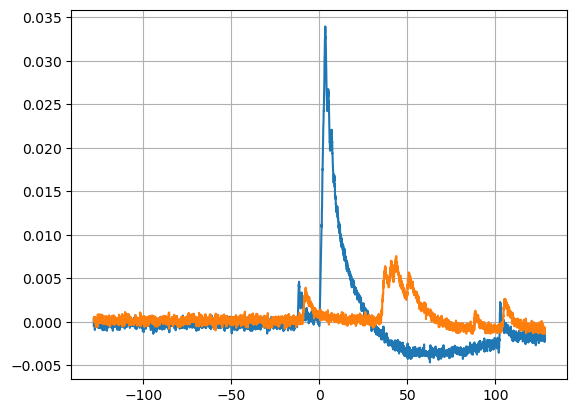

In [4]:
t=data["metadata"]["time_series"]*1e9
i=4
plot(t, data[1][i])
plot(t, data[2][i])

# xlim(-20,100)
grid()

print("integral ratio", sum(data[1][0][data[1][0]>0])/sum(data[2][0][data[2][0]>0]))
print("amplitude ratio", max(data[1][0])/max(data[2][0]))

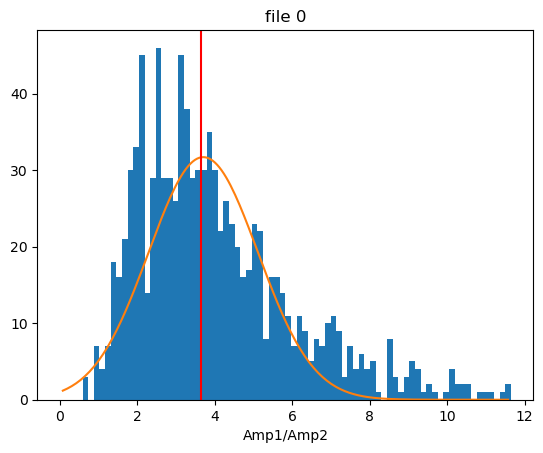

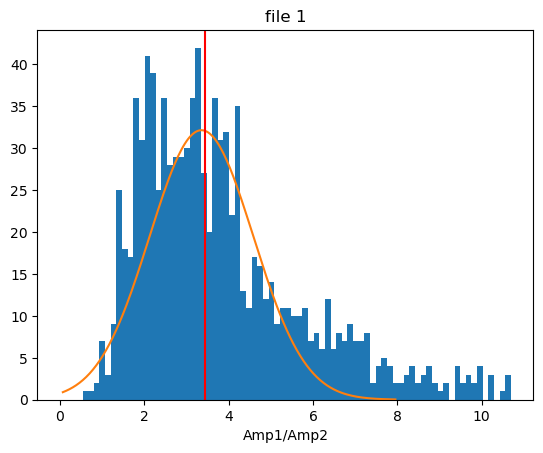

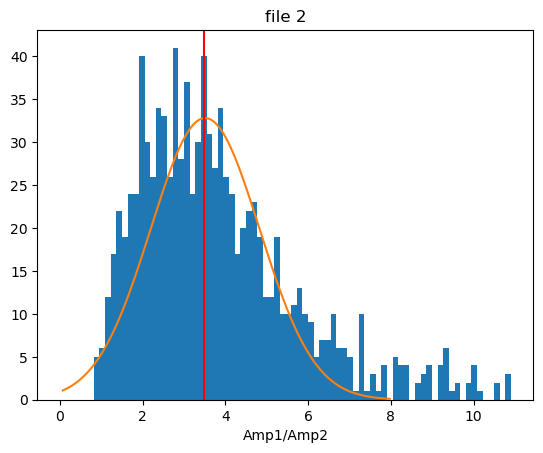

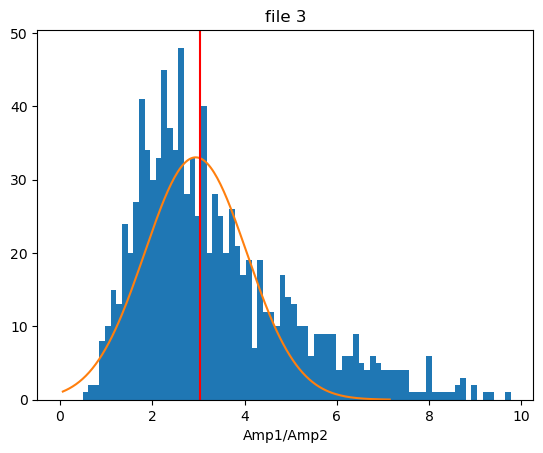

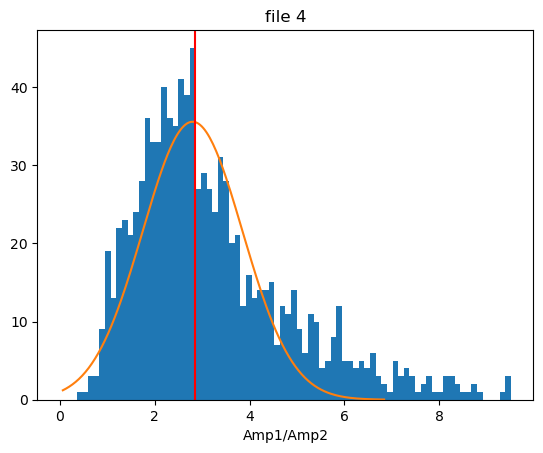

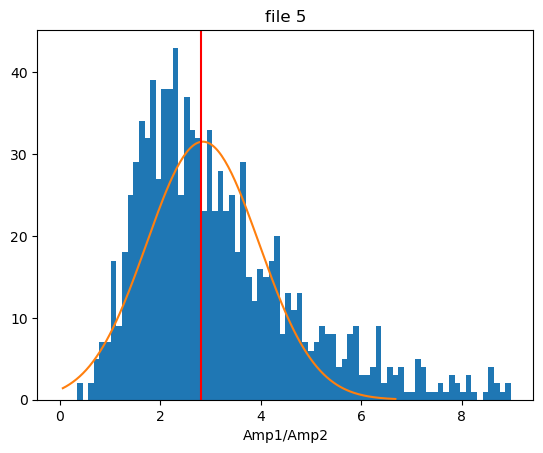

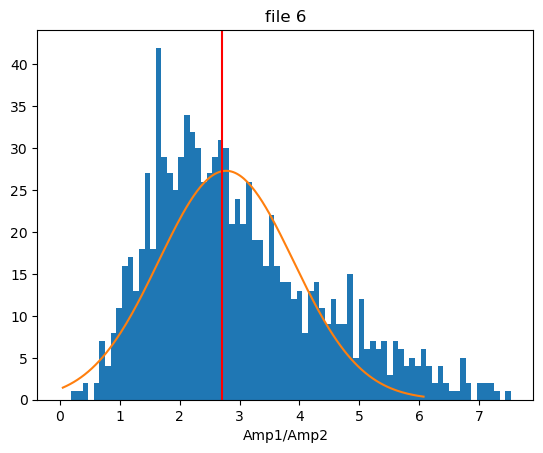

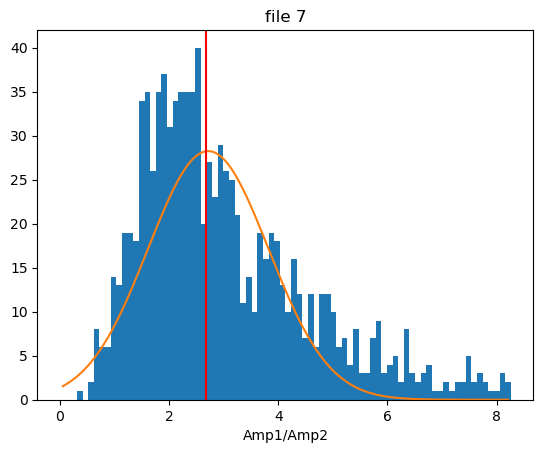

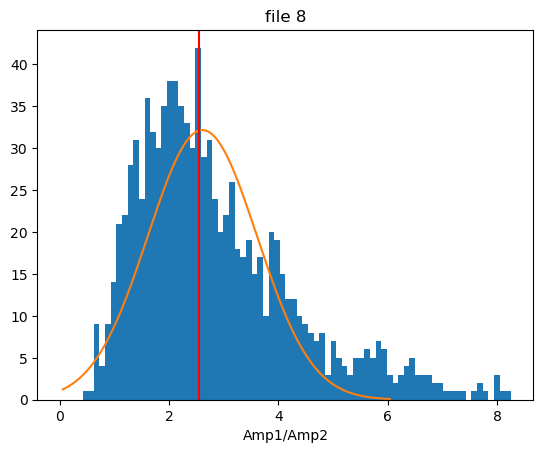

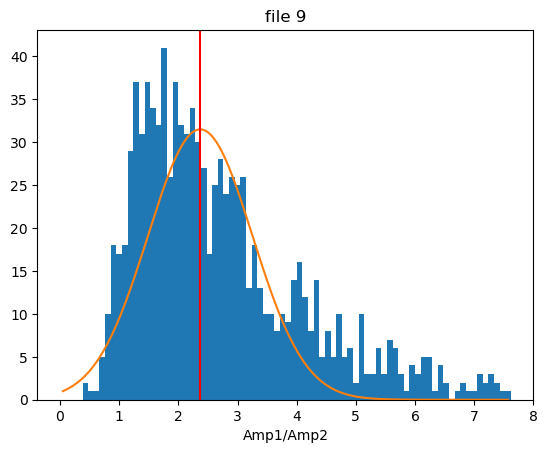

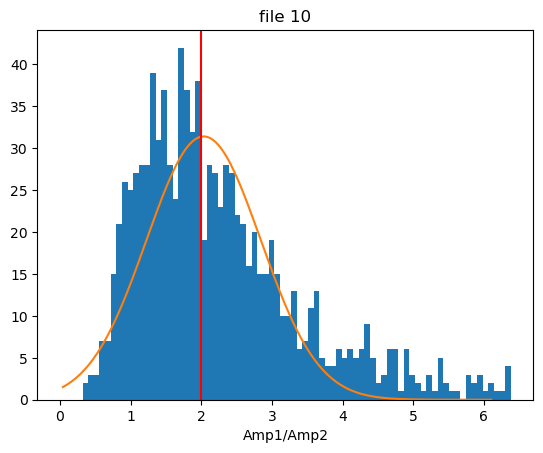

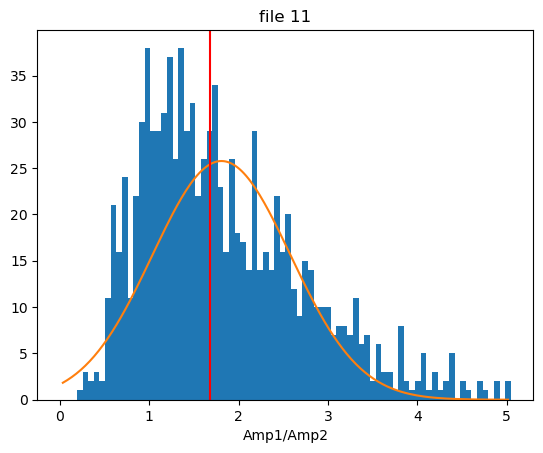

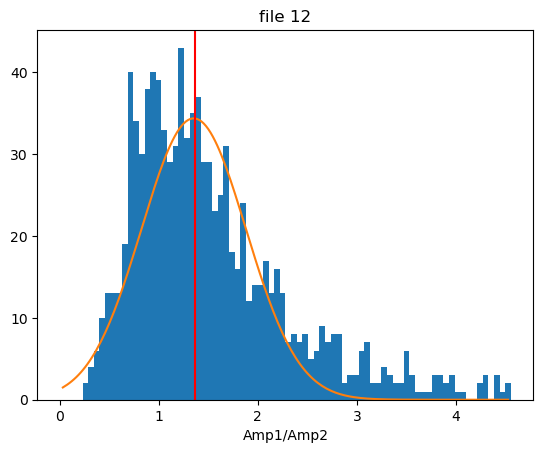

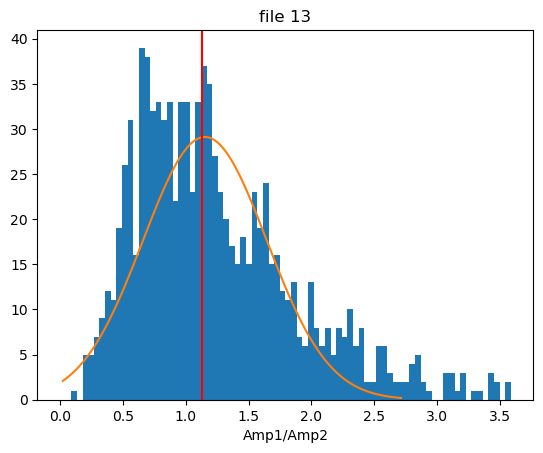

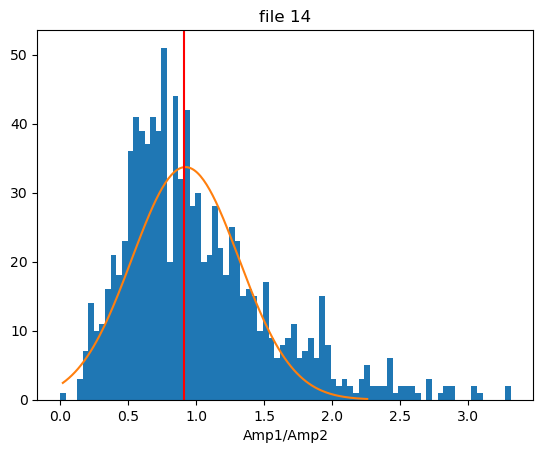

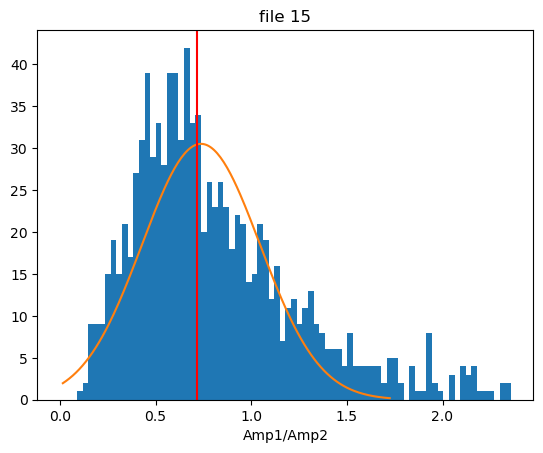

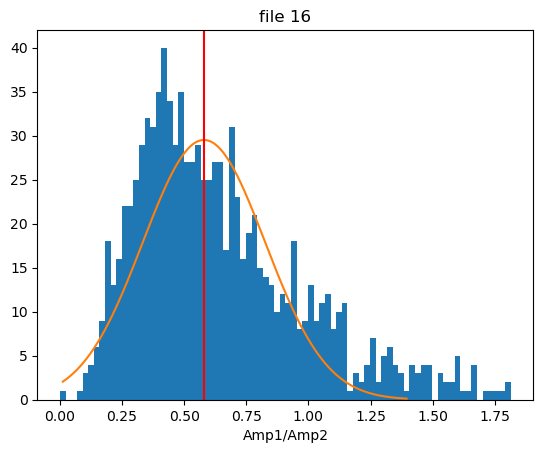

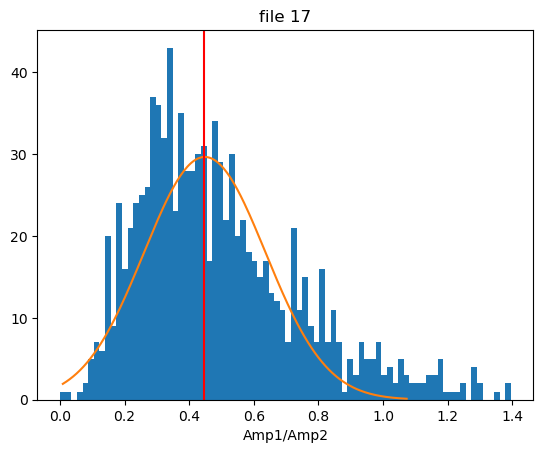

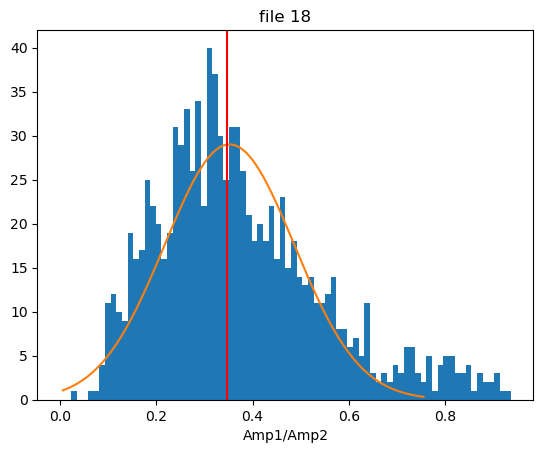

In [15]:
distance_all = []
amp1_all = []
amp2_all = []
amp_ratio = []
amp_ratio_unc = []
for i in filelist:
# for i in range(12):
    data=joblib.load(filepath+f"attenuation_{i}.joblib")
    amp1 = np.array([np.max(scipy.ndimage.gaussian_filter(trace, 10))-np.mean(trace[:2048]) for trace in data[1]])
    amp2 = np.array([np.max(scipy.ndimage.gaussian_filter(trace, 10))-np.mean(trace[:2048]) for trace in data[2]])
    int1 = np.array([np.sum(trace[(trace-np.mean(trace[:2048]))>0])for trace in data[1]])
    int2 = np.array([np.sum(trace[(trace-np.mean(trace[:2048]))>0])for trace in data[2]])
    ratio = amp1/amp2
    # ratio = int1/int2

    # h = np.histogram(ratio, bins=100)
    h = hist(ratio, bins=80, range=(0,np.quantile(ratio, 0.98)))
    popt, pcov, info, f = hp.fit_hist(hp.Gauss,h,
                                      p0=[max(h[0]),np.median(ratio),np.std(ratio)],
                                      fit_range=[np.median(ratio)-2*np.std(ratio), np.median(ratio)+2*np.std(ratio)],
                                      makeplot=True, label="")
    title(f"file {i}")
    xlabel("Amp1/Amp2")

    axvline(np.median(ratio),color="r")
    show()

    distance_all.append(filelist[i]+distance_offset)
    amp1_all.append(np.mean(amp1))
    amp2_all.append(np.mean(amp2))
    # amp_ratio.append(np.median(ratio))
    # amp_ratio_unc.append(np.std(ratio))
    amp_ratio.append(popt[1])
    amp_ratio_unc.append(np.sqrt(pcov[1][1]))

In [225]:
# plot(amp1_all)
# plot(amp2_all)
# # ylim(0,)

In [226]:
# def decay_2x_double(x, l_slow, l_fast, L0, alpha):
#     a1=  alpha*np.exp(-x/l_slow)+(1-alpha)*np.exp(-x/l_fast)
#     a2=  alpha*np.exp(-(L0-x)/l_slow)+(1-alpha)*np.exp(-(L0-x)/l_fast)
#     return a1/a2

# plot(x, decay_2x_double(x,*[10,1800, 600,0.1]))

In [8]:
reload(hp)

<module 'helper_basic' from '/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../Mu-Helper/muhelper/helper_basic.py'>

[7.46099170e+00 4.59066298e+02 5.63836638e+02 5.00142189e-01]
[5.71802427 8.55667245 6.18956754 0.38021807]


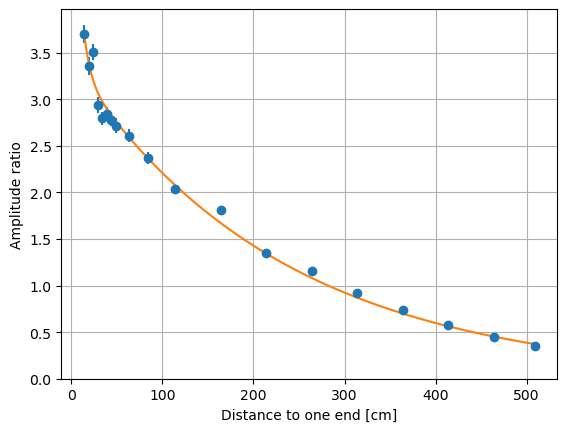

In [21]:
errorbar(distance_all, amp_ratio, yerr=amp_ratio_unc, fmt="o")

def decay_2x_single(x, l_slow, L0):
    # L0=610
    return  np.exp((L0-2*x)/l_slow)

def decay_2x_double(x, l_slow, l_fast, L0, alpha):
    a1=  alpha*np.exp((L0-2*x)/l_slow)      + (1-alpha)*np.exp((L0-2*x)/l_fast)
    return a1

def decay_2x_double_ratio(x, l_slow, l_fast, L0, alpha):
    a1=  alpha*np.exp(-x/l_slow)      + (1-alpha)*np.exp(-x/l_fast)
    a2=  alpha*np.exp(-(L0-x)/l_slow) + (1-alpha)*np.exp(-(L0-x)/l_fast)
    return a1/a2



# def decay_2x_single(x, l_slow):
#     L0=300
#     return  np.exp((L0-2*x)/l_slow)

x=np.array(distance_all)
y=np.array(amp_ratio)
data_points = {"x":x,"y":y,"yerr":amp_ratio_unc}
joblib.dump(data_points,filepath + "attenuation_bcf92_data.joblib",compress=0)
# popt, pcov, info, f = hp.fit_curve(decay_2x_single,x,y, sigma=amp_ratio_unc,p0=[500, 600], maxfev=1000, makeplot=True)
popt, pcov, info, f = hp.fit_curve(decay_2x_double_ratio,x,y, sigma=amp_ratio_unc,
                                    p0=[30,520, 600,0.1],
                                    bounds=([0,300,100,0], [200,10000,1000,1]),
                                      maxfev=50000, makeplot=True)

print(popt)
print(np.sqrt(np.diag(pcov)))
ylim(0,)
grid()
xlabel("Distance to one end [cm]")
ylabel("Amplitude ratio")
savefig(filepath+"Result_attenuation_fit_BCF_92.jpg")

In [60]:
# pulse_save = {"time_series_ns":time_series,
#               "averaged_pulse_1pe_volt":trace_aligned_avg}
# joblib.dump(pulse_save,"data_waveform/averaged_pulse_1pe_preamp_v4_40.7V.joblib")